# Predict using model


In [2]:
import os 
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt 
import random
# from tracker import Tracker

In [3]:
def getFileNames(directory_path):
    try:
        file_names = [file for file in os.listdir(directory_path) if os.path.join(directory_path, file)]
        return file_names
    except FileNotFoundError:
        print(f'Directory not found: {directory_path}')
        return []
    except IOError as f:
        print(f'Error reading the directory: {f}')
        return []
    

In [4]:
train_images = getFileNames("train/images")
val_images = getFileNames("valid/images")

In [2]:
!pip install onnxruntime

     ---------------------------------------- 6.7/6.7 MB 11.6 MB/s eta 0:00:00
     ---------------------------------------- 46.0/46.0 kB 2.2 MB/s eta 0:00:00
     ------------------------------------- 422.5/422.5 kB 27.5 MB/s eta 0:00:00
     ---------------------------------------- 86.8/86.8 kB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 kB 5.7 MB/s eta 0:00:00


In [12]:
print(f'Number of training images: {len(train_images)}')
print(f'Number of validation images: {len(val_images)}')

Number of training images: 14431
Number of validation images: 4810


In [13]:
model_path = "Models/best_re_f.pt"
yolo_path = "Models/yolov8n.pt"
onnx_path = "Models/best_re_f.onnx"
# model = YOLO(model_path)

Number selected by random: 302


0: 1280x1280 12 heads, 316.1ms
Speed: 16.3ms preprocess, 316.1ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)


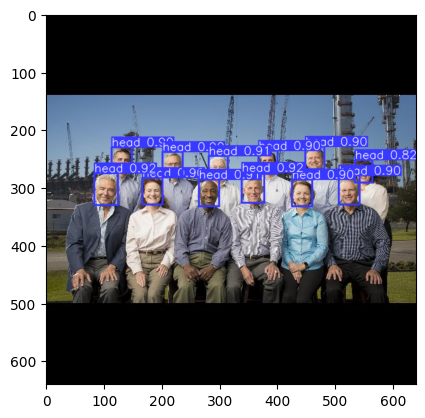

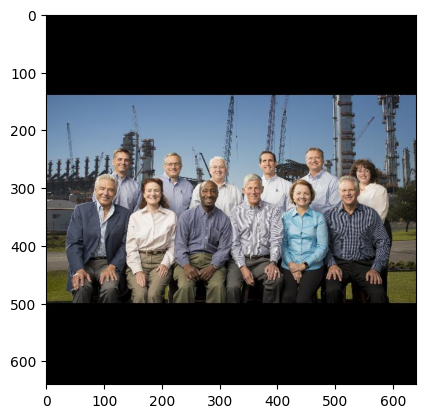

In [25]:
randomIndex = random.randint(0, len(val_images))
print(f"Number selected by random: {randomIndex}")
image = cv2.imread("valid/images/"+val_images[randomIndex])
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = model(rgb_image, conf=0.3)[0]
res_plotted = results.plot()
plt.imshow(res_plotted)
plt.show()
plt.imshow(rgb_image)
plt.show()


In [ ]:
# Open the video file
video_path = "data/Evening_Dynamic_Back_Medium_NoMasks.MOV"
cap = cv2.VideoCapture(video_path)
cv2.namedWindow('YOLOv8 Inference', cv2.WINDOW_NORMAL) 
# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame, conf=0.2)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


In [10]:
video_path = "data/Morning_Static_Back_Compact_NoMask_Intruders.mp4"

In [ ]:
cap = cv2.VideoCapture(video_path)
cv2.namedWindow('YOLOv8 Inference 2', cv2.WINDOW_NORMAL)
frame_count = 0
start_time = cv2.getTickCount()
highest_fps=0
while True:
    # Read a frame from the video stream
    ret, frame = cap.read()
    # Run YOLOv8 inference on the frame
    results = model(frame, conf=0.4, device='cuda')
    annotated_frame = results[0].plot()
    
    if not ret:
        break

    frame_count += 1
    # Check if 10 seconds (or any other duration) have elapsed
    # if frame_count == 10 * cap.get(cv2.CAP_PROP_FPS):
    end_time = cv2.getTickCount()
    elapsed_time = (end_time - start_time) / cv2.getTickFrequency()
    fps = frame_count / elapsed_time
    print(f"FPS: {fps:.2f}")
    cv2.putText(annotated_frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Reset the frame count and start time
    frame_count = 0
    start_time = cv2.getTickCount()
    # Display the frame in the named window
    cv2.imshow('YOLOv8 Inference 2', annotated_frame)
    # Check for the 'q' key to exit the loop
    if (fps>highest_fps):
        highest_fps = fps
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
cap.release()
cv2.destroyAllWindows()

In [12]:
highest_fps

13.41833184586652

In [ ]:
tracker = Tracker()
video_path = "data/Morning_Static_Front_Sparse_NoMask_Intruders (2).mp4"
cap = cv2.VideoCapture(video_path)
cv2.namedWindow('YOLOv8 Inference 2', cv2.WINDOW_NORMAL)
frame_count = 0
start_time = cv2.getTickCount()
highest_fps=0
flag = True
while True:
    # Read a frame from the video stream
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Run YOLOv8 inference on the frame
    results = model(frame, conf=0.4, device='cuda')[0]
    # annotated_frame = results[0].plot()
    detections = []
    for result in results.boxes.data.tolist():
        x1,y1,x2,y2,score,class_id = result
        x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
        detections.append([x1,y1,x2,y2,score])
        flag = False
        
    if(flag):
        cv2.imshow('YOLOv8 Inference 2', frame)
        continue

    tracker.update(frame, detections)

    for track in tracker.tracks:
        bbox = track.bbox
        x1,y1,x2,y2 = bbox
        track_id = track.track_id
        cv2.rectangle(frame, (int(x1), int(y1)),(int(x2), int(y2)), (0,255,0),4 )
        cv2.putText(frame, f"ID: {track_id}", (int(x1), int(y1-10)), 
            cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0,255,0),3, cv2.LINE_AA)

    frame_count += 1
    # Check if 10 seconds (or any other duration) have elapsed
    # if frame_count == 10 * cap.get(cv2.CAP_PROP_FPS):
    end_time = cv2.getTickCount()
    elapsed_time = (end_time - start_time) / cv2.getTickFrequency()
    fps = frame_count / elapsed_time
    print(f"FPS: {fps:.2f}")
    cv2.putText(annotated_frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Reset the frame count and start time
    frame_count = 0
    start_time = cv2.getTickCount()



    # Display the frame in the named window
    cv2.imshow('YOLOv8 Inference 2', frame)
    # Check for the 'q' key to exit the loop
    if (fps>highest_fps):
        highest_fps = fps
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
cap.release()
cv2.destroyAllWindows()

In [32]:
from ultralytics import YOLO

model = YOLO('Models/best_re_f.pt')  # load a custom trained

# Export the model
model.export(format='onnx')

WARNING  Models/best_re_f.pt appears to require 'ultralytics.utils', which is not in ultralytics requirements.
AutoInstall will run now for 'ultralytics.utils' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['ultralytics.utils'] not found, attempting AutoUpdate...
requirements:  Command 'pip install --no-cache "ultralytics.utils"  ' returned non-zero exit status 1.


ModuleNotFoundError: No module named 'ultralytics.utils'

In [29]:
!pip install --no-cache "ultralytics.utils

ERROR: Could not find a version that satisfies the requirement ultralytics.utils (from versions: none)
ERROR: No matching distribution found for ultralytics.utils


# Running Inference Using Onnx

In [3]:
import cv2
# Load Model
net = cv2.dnn.readNet('best_re_f.onnx')

In [4]:
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4
CONFIDENCE_THRESHOLD = 0.4

# Define yolov8 classes
CLASESS_YOLO = [
 'head'
]

In [7]:

image = cv2.imread('test.jpg')
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image = cv2.imread('bus.jpg')

blob = cv2.dnn.blobFromImage(image, 1/255.0, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
preds = preds.transpose((0, 2, 1))

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\layers\reshape_layer.cpp:109: error: (-215:Assertion failed) total(srcShape, srcRange.start, srcRange.end) == maskTotal in function 'cv::dnn::computeShapeByReshapeMask'


In [ ]:
# Extract output detection
class_ids, confs, boxes = list(), list(), list()

image_height, image_width, _ = image.shape
x_factor = image_width / INPUT_WIDTH
y_factor = image_height / INPUT_HEIGHT

rows = preds[0].shape[0]

for i in range(rows):
    row = preds[0][i]
    conf = row[4]
    
    classes_score = row[4:]
    _,_,_, max_idx = cv2.minMaxLoc(classes_score)
    class_id = max_idx[1]
    if (classes_score[class_id] > .25):
        confs.append(conf)
        label = CLASESS_YOLO[int(class_id)]
        class_ids.append(label)
        
        #extract boxes
        x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
        left = int((x - 0.5 * w) * x_factor)
        top = int((y - 0.5 * h) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)
        box = np.array([left, top, width, height])
        boxes.append(box)
        
r_class_ids, r_confs, r_boxes = list(), list(), list()

indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.25, 0.45) 
for i in indexes:
    r_class_ids.append(class_ids[i])
    r_confs.append(confs[i])
    r_boxes.append(boxes[i])